In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from pathlib import Path
import json

from scipy.stats import norm, lognorm

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [2]:
# baseDir = r'/u/home/l/laxmanda/project-hvburton/autoWoodSDA/'
baseDir = r'/Users/laxmandahal/Desktop/UCLA/Phd/Research/woodSDA/autoWoodSDA_public'

buildingID = 'MFD6B'
resultRootDir = os.path.join(baseDir, 'Results', buildingID)

In [3]:
from GLMClass import GLMProbitClass
from MLEClass import MaximumLikelihoodMethod

In [6]:
df_collapse = pd.read_csv(os.path.join(baseDir, 'Results', 'CollapseCount_woodSDA_vs_ATC116.csv'))
hazardLevel = df_collapse.IM
df_collapse = df_collapse.drop(columns='IM')
colNames = df_collapse.columns
numGM = 44 * np.ones(len(hazardLevel))
## picking some dummy return periods to feed into the class
returnPeriod = [15, 25, 50, 75, 100, 150, 250, 500, 1000, 2500, 2700, 3000, 3300, 3500, 3700, 4000, 8000, 12000]
rate = [1/i for i in returnPeriod]

In [7]:
temp2 = []
for i in colNames: 
    numCount = np.array(df_collapse['%s'%i])
    mleClass = MaximumLikelihoodMethod(hazardLevel, numCount, numGM, rate)
    temp2.append({'Building Name':i,
                 r'Median($\theta$)':mleClass.theta[0],
                 r'log-std($\beta$)':mleClass.theta[1],
                 r'Var[$\theta$]':mleClass.vcov_erf[0,0], #using error function 
                 r'Var[$\beta$]':mleClass.vcov_erf[1,1],
                 r'QVar[$\theta$]':mleClass.sandwich[0,0],
                 r'QVar[$\beta$]':mleClass.sandwich[1,1],
                 r'CoV_$\theta$': np.sqrt(mleClass.vcov_erf[0,0])/mleClass.theta[0],
                 r'CoV_$\beta$': np.sqrt(mleClass.vcov_erf[1,1])/mleClass.theta[1],
                 r'QCoV_$\theta$': np.sqrt(mleClass.sandwich[0,0])/mleClass.theta[0],
                 r'QCoV_$\beta$': np.sqrt(mleClass.sandwich[1,1])/mleClass.theta[1], 
                 r'MAFC($\lambda_c$)':mleClass.meanLambdaCollapse,
                 r'MLEStd[$\lambda_c$]':mleClass.MAFC(qmleTag = False),
                 r'QMLEStd[$\lambda_c$]':mleClass.MAFC(qmleTag = True),
                 '50yr_ProbCollapse':mleClass.getProbCollapse_years(numYear = 50),
                  'Var(lambdaCSimulated)':mleClass.varCollapseRate
        
    })
    
MLEresult = pd.DataFrame(temp2)
MLEresult.head(10)

,Building Name,Median($\theta$),log-std($\beta$),Var[$\theta$],Var[$\beta$],QVar[$\theta$],QVar[$\beta$],CoV_$\theta$,CoV_$\beta$,QCoV_$\theta$,QCoV_$\beta$,MAFC($\lambda_c$),MLEStd[$\lambda_c$],QMLEStd[$\lambda_c$],50yr_ProbCollapse,Var(lambdaCSimulated)
0,AutoWoodSDA,1.930043,0.251130,0.001299,0.000295,0.000925,0.000391,0.018677,0.068425,0.01576,0.078720,0.003118,0.000139,0.000149,0.144366,3.143914e-07
1,ATC116,1.853741,0.242601,0.001179,0.000284,0.000550,0.000128,0.018519,0.069493,0.01265,0.046688,0.003283,0.000152,0.000089,0.151384,3.530687e-07


In [8]:
np.log(MLEresult[MLEresult['Building Name']=='AutoWoodSDA'][r'Median($\theta$)'][0])

0.6575421111400516

In [9]:
MLEresult['Building Name']

0    AutoWoodSDA
1         ATC116
Name: Building Name, dtype: object

In [10]:
MLEresult[MLEresult['Building Name']=='ATC116'][r'Median($\theta$)'].values[0]

1.8537410643194938

In [11]:
numGM

array([44., 44., 44., 44., 44., 44., 44., 44., 44., 44., 44., 44., 44.,
       44., 44., 44., 44., 44.])

In [12]:
MLEresult[MLEresult['Building Name']=='AutoWoodSDA'][r'log-std($\beta$)'][0]

0.2511298340728301

In [13]:
X_range = np.linspace(0.01, 5.5, 205)

empirical_prob_atc116 = df_collapse['ATC116'].values / numGM
empirical_prob_woodSDA = df_collapse['AutoWoodSDA'].values / numGM

theta_atc116 = MLEresult[MLEresult['Building Name']=='ATC116'][r'Median($\theta$)'].values[0]
beta_atc116 = MLEresult[MLEresult['Building Name']=='ATC116'][r'log-std($\beta$)'].values[0]

theta_woodSDA = MLEresult[MLEresult['Building Name']=='AutoWoodSDA'][r'Median($\theta$)'].values[0]
beta_woodSDA = MLEresult[MLEresult['Building Name']=='AutoWoodSDA'][r'log-std($\beta$)'].values[0]
## fitted fragility curve
fitted_Pc_atc116 = norm.cdf(np.log(X_range), 
                            loc=np.log(theta_atc116),
                           scale=beta_atc116)
fitted_Pc_woodSDA = norm.cdf(np.log(X_range), 
                            loc=np.log(theta_woodSDA),
                           scale= beta_woodSDA)
## adjusting collapse capacity for spectral shape factor (SSF)
## SSF value of 1.34 is directly obtained from FEMA P-2139-2 Table 5-2
SSF = 1.34
## FEMA P-2139-2 specifies total dispersion be between 0.4-0.6. Taking 0.5 for demonstration
beta_TOT = 0.5
adjusted_Pc_atc116 = norm.cdf(np.log(X_range), 
                            loc=np.log(theta_atc116 * SSF),
                           scale=beta_TOT)
adjusted_Pc_woodSDA = norm.cdf(np.log(X_range),
                              loc=np.log(theta_woodSDA * SSF),
                              scale=beta_TOT)

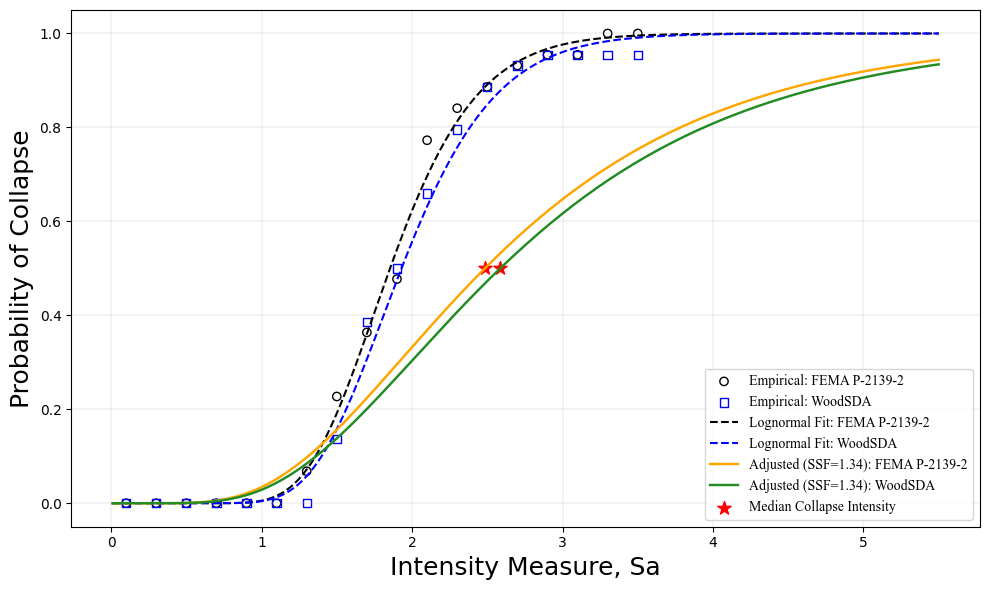

In [14]:

fig, ax = plt.subplots(figsize=(10,6))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16


ax.scatter(hazardLevel, empirical_prob_atc116 , color = 'black', marker = 'o', 
            facecolors='none', edgecolors='black',
            label = 'Empirical: FEMA P-2139-2')
ax.scatter(hazardLevel, empirical_prob_woodSDA , color = 'green', marker = 's',
            facecolors='none', edgecolors='blue',
            label = 'Empirical: WoodSDA')
## plot fitted probability 
ax.plot(X_range, fitted_Pc_atc116, color='black', linestyle='dashed',
        linewidth=1.5, label='Lognormal Fit: FEMA P-2139-2')
ax.plot(X_range, fitted_Pc_woodSDA, color='blue', linestyle='dashed',
        linewidth=1.5, label='Lognormal Fit: WoodSDA')
ax.plot(X_range, adjusted_Pc_atc116, color='orange', linestyle='solid',
        linewidth=1.75, label='Adjusted (SSF=1.34): FEMA P-2139-2')
ax.plot(X_range, adjusted_Pc_woodSDA, color='forestgreen', linestyle='solid',
        linewidth=1.75, label='Adjusted (SSF=1.34): WoodSDA')

plt.scatter([theta_atc116*SSF, theta_woodSDA*SSF], [0.5, 0.5], s = 100, color = 'red', 
            marker = '*', label = 'Median Collapse Intensity')

# xaxistick = np.array([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5])
# yaxistick = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
# ax.set_xticks(xaxistick)
# ax.set_yticks(yaxistick)
ax.set_xlabel('Intensity Measure, Sa', fontsize=18)
ax.set_ylabel('Probability of Collapse', fontsize=18)

ax.grid(which = 'major')
plt.legend(loc='lower right')
plt.grid(linewidth = 0.2)
plt.tight_layout()
# plt.savefig(os.path.join(baseDir,'Results', f'Collapse_fragility_comparison_{buildingID}.png'))

In [15]:
print(theta_atc116*SSF, theta_woodSDA*SSF)

2.484013026188122 2.5862571769190263


In [25]:
def smooth_list(list_of_old_values):
    """
    """
    list_of_new_values = []

    for i in range(len(list_of_old_values)):

        # For the first value
        if i == 0:
            # if the current loss/downtime value is higher than the next loss/downtime value,
            # take the average of the current and next loss/downtime value
            current_val = list_of_old_values[i]
            next_val = list_of_old_values[i+1]
            if (current_val > next_val):
                list_of_new_values.append(
                    round(np.average(list_of_old_values[i:i+2])))
            else:
                list_of_new_values.append(list_of_old_values[i])

        # For all values except the first and last 2
        elif i < (len(list_of_old_values)-2):
            # if the current loss/downtime value is greater than the next loss/downtime value,
            # take the average of the previous, current, and next loss/downtime value.
            current_val = list_of_old_values[i]
            previous_val = list_of_new_values[i-1]  # from new curve
            next_val = list_of_old_values[i+1]      # from old curve
            if (current_val < previous_val):
                list_of_new_values.append(
                    round(np.average(list_of_old_values[i-1:i+2]))) #rounds to int.. careful if using this function with vals <1 -MA
            elif current_val > next_val:
                list_of_new_values.append(
                    round(np.average(list_of_old_values[i-1:i+2])))
            else:
                list_of_new_values.append(list_of_old_values[i])

        # For the last value
        else:
            # if the current loss/downtime value is lower than the previous loss/downtime value,
            # take the average of the previous and current loss/downtime value.
            current_val = list_of_old_values[i]
            previous_val = list_of_new_values[i-1]      #updated to say 'new' -MA 5/2023
            if (current_val < previous_val):
                list_of_new_values.append(
                    round(np.average(list_of_old_values[i-1:i+1])))
            else:
                list_of_new_values.append(list_of_old_values[i])

        # Perform a check. Current value can't be less than previous value
        if i > 0:
            if list_of_new_values[i] < list_of_new_values[i-1]:
                # set current value equal to previous value
                list_of_new_values[i] = list_of_new_values[i-1]

    return list_of_new_values



In [65]:
buildingID = 'MFD6B'
# buildingID = 'MFD6B_collapse_10'
resultRootDir = os.path.join(baseDir, 'Results', buildingID)

buildingID = 'MFD6B'
df_edp = pd.read_csv(os.path.join(resultRootDir, f'EDP_Profile_{buildingID}.csv'))
df_loss = pd.read_csv(os.path.join(resultRootDir, f'Loss_pelicun_{buildingID}.csv'), index_col=0)
df_recovery = pd.read_csv(os.path.join(resultRootDir, f'Loss_ATC_RecoveryTimes_{buildingID}.csv'))

In [59]:
df_loss.tail()

,BuildingID,Replacement_Cost,Mean_Repair_Cost,Median_Repair_Cost,RepairCost_10th_percentile,RepairCost_25th_percentile,RepairCost_75th_percentile,RepairCost_90th_percentile,RepairCost_std,Hazard_level,SA(T1=0.3s),Max SDR,Max PFA,Max RDR,Max PGA
13,MFD6B,7133184,5.857209e+06,7.133176e+06,1.360350e+06,7.133146e+06,7.133194e+06,7.133208e+06,2.391923e+06,14,2.7,0.359320,3.913271,0.359320,1.996539
14,MFD6B,7133184,6.146659e+06,7.133178e+06,1.443227e+06,7.133155e+06,7.133195e+06,7.133209e+06,2.168167e+06,15,2.9,0.517296,3.978885,0.517296,2.140382
15,MFD6B,7133184,6.027140e+06,7.133178e+06,1.403421e+06,7.133153e+06,7.133195e+06,7.133209e+06,2.268651e+06,16,3.1,0.388604,3.700305,0.388604,2.289979
16,MFD6B,7133184,6.078525e+06,7.133178e+06,1.436452e+06,7.133154e+06,7.133195e+06,7.133209e+06,2.223493e+06,17,3.3,0.539635,3.940345,0.539635,2.439575
17,MFD6B,7133184,6.402217e+06,7.133180e+06,1.551774e+06,7.133161e+06,7.133196e+06,7.133210e+06,1.918070e+06,18,3.5,0.406379,3.995114,0.406379,2.583418


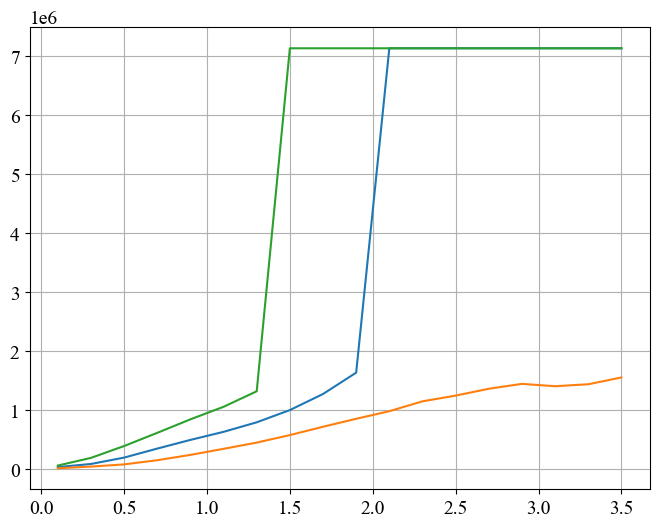

In [60]:
fig, ax = plt.subplots(figsize=(8,6))
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# sns.lineplot(data=df_loss, x='SA(T1=0.3s)', y= 'Median_Repair_Cost',
#                 errorbar=None, hue=None,
#                 markers=False, dashes=False, lw = 1.5, estimator=None, color='black',
#                 ax=ax)
plt.plot(df_loss['SA(T1=0.3s)'], df_loss['Median_Repair_Cost'])
plt.plot(df_loss['SA(T1=0.3s)'], df_loss['RepairCost_10th_percentile'])
plt.plot(df_loss['SA(T1=0.3s)'], df_loss['RepairCost_90th_percentile'])
plt.grid()

In [61]:
df_loss['Median_Repair_Cost'] = smooth_list(df_loss['Median_Repair_Cost'].values)
df_loss['RepairCost_90th_percentile'] = smooth_list(df_loss['RepairCost_90th_percentile'].values)
df_loss['RepairCost_10th_percentile'] = smooth_list(df_loss['RepairCost_10th_percentile'].values)

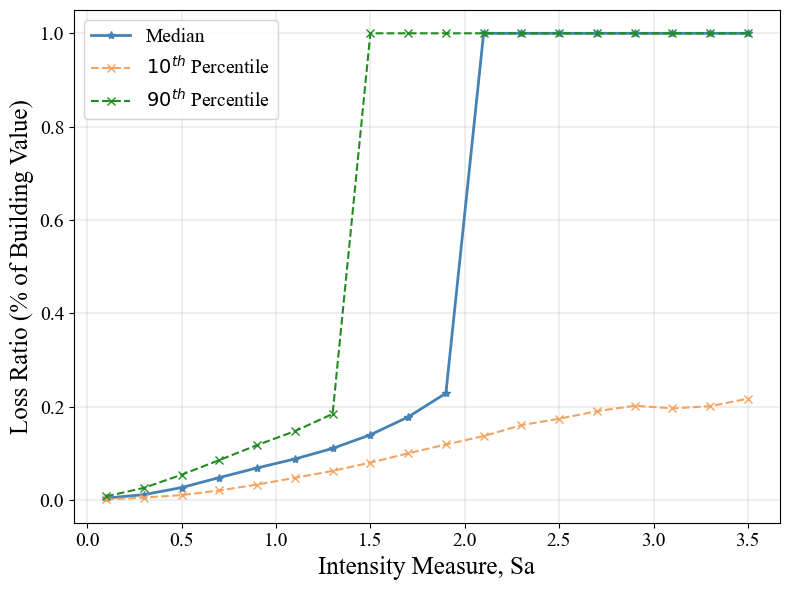

In [68]:
fig, ax = plt.subplots(figsize=(8,6))
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14


ax.plot(df_loss['SA(T1=0.3s)'], df_loss['Median_Repair_Cost'] / np.max(df_loss['Median_Repair_Cost']),
        linewidth=2, marker='*', color='steelblue',  label=r'Median')
ax.plot(df_loss['SA(T1=0.3s)'], df_loss['RepairCost_10th_percentile'] / np.max(df_loss['Median_Repair_Cost']),
        linewidth=1.5, marker='x', color='sandybrown', linestyle='dashed', label=r'$10^{th}$ Percentile')
ax.plot(df_loss['SA(T1=0.3s)'], df_loss['RepairCost_90th_percentile'] / np.max(df_loss['Median_Repair_Cost']),
        linewidth=1.5, marker='x', color='forestgreen', linestyle='dashed', label=r'$90^{th}$ Percentile')
ax.set_xlabel('Intensity Measure, Sa', fontsize=18)
ax.set_ylabel('Loss Ratio (% of Building Value)', fontsize=18)
plt.grid(linewidth=0.3)
plt.legend(fontsize=14)
plt.tight_layout()

fig_output_fp = r'/Users/laxmandahal/Desktop/UCLA/Phd/Research/woodSDA/Paper/graphics'
plt.savefig(os.path.join(fig_output_fp, 'Loss_ratio_curve.png'),
            dpi=600, bbox_inches='tight')

In [ ]:
df_recovery.head()

<Axes: xlabel='SA(T1=0.3s)', ylabel='Median Functional Recovery'>

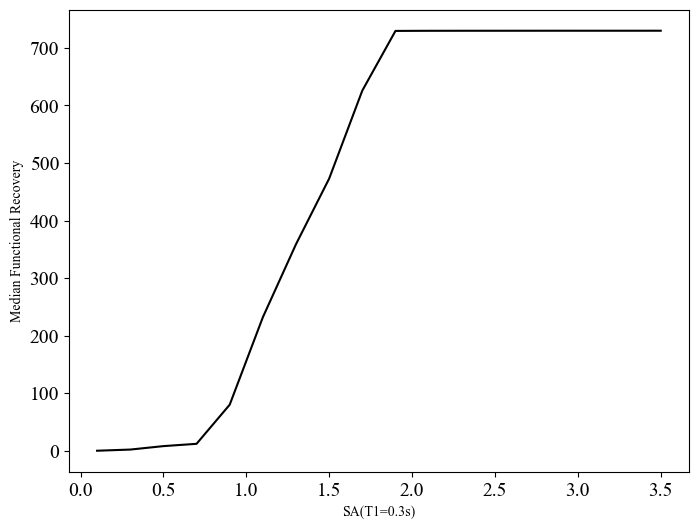

In [66]:
fig, ax = plt.subplots(figsize=(8,6))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

sns.lineplot(data=df_recovery, x='SA(T1=0.3s)', y= 'Median Functional Recovery',
                errorbar=None, hue=None,
                markers=False, dashes=False, lw = 1.5, estimator=None, color='black',
                ax=ax)

<Axes: xlabel='SA(T1=0.3s)', ylabel='Median Reoccupancy'>

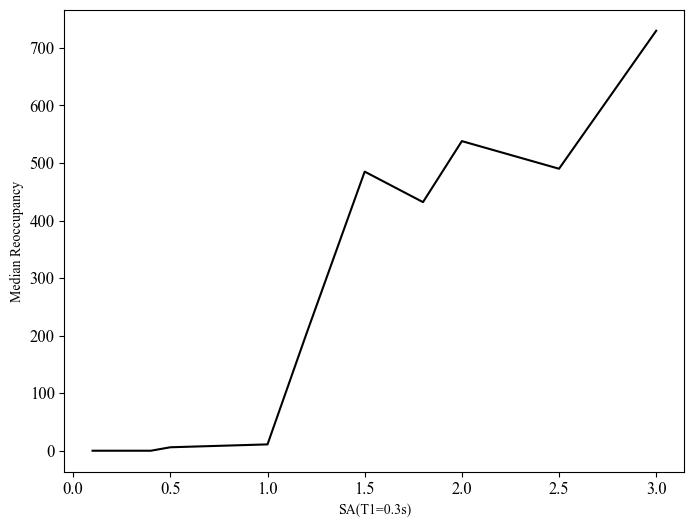

In [34]:
fig, ax = plt.subplots(figsize=(8,6))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

sns.lineplot(data=df_recovery, x='SA(T1=0.3s)', y= 'Median Reoccupancy',
                errorbar=None, hue=None,
                markers=False, dashes=False, lw = 1.5, estimator=None, color='black',
                ax=ax)

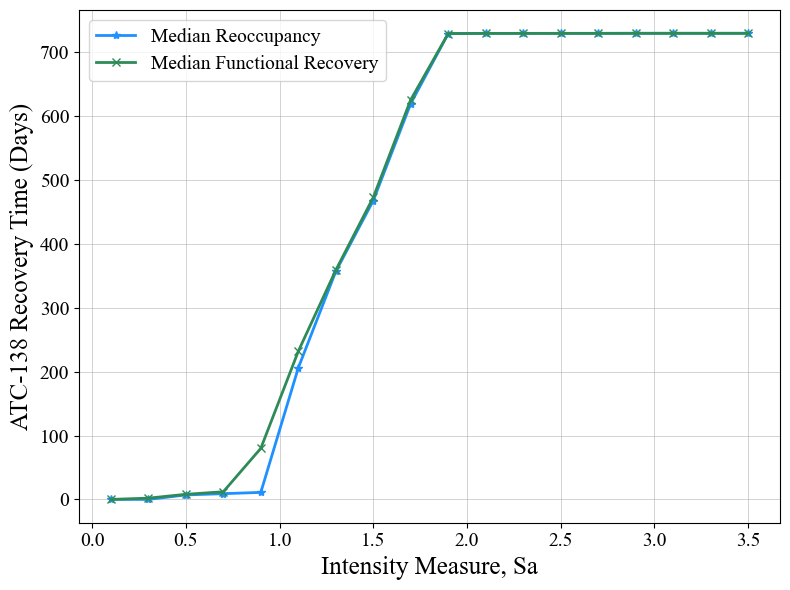

In [72]:
fig, ax = plt.subplots(figsize=(8,6))
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

plt.plot(df_recovery['SA(T1=0.3s)'].values, smooth_list(df_recovery['Median Reoccupancy'].values), 
         linewidth=2, marker='*', color='dodgerblue',  label=r'Median Reoccupancy')
plt.plot(df_recovery['SA(T1=0.3s)'].values, smooth_list(df_recovery['Median Functional Recovery'].values), 
         linewidth=2, marker='x', color='seagreen',  label=r'Median Functional Recovery')


ax.set_xlabel('Intensity Measure, Sa', fontsize=18)
ax.set_ylabel('ATC-138 Recovery Time (Days)', fontsize=18)
plt.grid(linewidth=0.4, visible=True)
plt.legend(fontsize=14)
plt.tight_layout()
fig_output_fp = r'/Users/laxmandahal/Desktop/UCLA/Phd/Research/woodSDA/Paper/graphics'
plt.savefig(os.path.join(fig_output_fp, 'recovery_curve.png'),
            dpi=600, bbox_inches='tight')

In [ ]:
plt.plot(df_loss['SA(T1=0.3s)'].values, smooth_list(df_loss['Median_Repair_Cost'].values), marker='*')
plt.xlabel('Intensity Measure, Sa(T1)', fontsize=16)
plt.ylabel('Median Repair Loss (USD)', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(resultRootDir, f'Loss_curve_{buildingID}.png'))

In [ ]:
plt.plot(df_recovery['SA(T1=0.3s)'].values, smooth_list(df_recovery['Median Functional Recovery'].values), 
         marker='*')
plt.xlabel('Intensity Measure, Sa(T1)', fontsize=16)
plt.ylabel('Median Functional Recovery Time (Days)', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(resultRootDir, f'funcRecovery_curve_{buildingID}.png'))